## Final Project Submission

Please fill out:
* Student name: Andrew Rohlman
* Student pace: Full Time
* Scheduled project review date/time: 3/22 at 12:00 PM CT
* Instructor name: Rafael Carrasco
* Blog post URL: https://rondo24.github.io/developing_patience_and_understanding_with_cnns


## Classifying Traffic Signs for Self Driving Cars

With self driving cars becoming more prevalent today, accuracy in their systems is crucial to getting passengers to their destinations safely and to reduce automobile accidents. One of the key systems in a self driving car is recognizing traffic signs and knowing what the vehicle should do in each scenario. The way self driving cars can recognize and classify a traffic sign is to analyze an image of the sign and run it through a Deep Convolutional Neural Network (CNN) for identification. I am tasked with creating a CNN that can classify these traffic signs. I was given over 30,000 images of 43 different traffic signs to create the CNN architecture to correctly train and classify them.

Here is my approach to create this CNN:

1) Pre process the training images (i will use 10,000 of the 30,000 images for training and validation to reduce computing time)

2) Place my training images into a numpy array

3) Develop and train and update a CNN

4) Use our final CNN on the testing data (12,000 test images)

First thing I want to do is import all necessary libraries for the task

In [1]:
import numpy as np #converting images into numpy arrays
import pandas as pd #used to pull the testing classifications
import matplotlib.pyplot as plt #visualize the CNN epoch training
%matplotlib inline 

from sklearn.model_selection import train_test_split

#libraries for creating the Convolutional Neural Network
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_data_format('channels_first')

#Used for image preprocessing
from skimage import color, exposure, transform
from skimage import io

#Used for converting images into our numpy arrays
import os
import glob
import re

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


The first step in this process is pre processing our images for our CNN to analyze our images more easily. Not all the images are the same size or are cropped to easily recognize the signs in the pictures. Also, there are different shades of colors depending on the angles the images are of the sign. So the below "preprocess" function with take any image inputted and pre process them for these attributes. Credit for guidance on the preprocessing code goes to: https://chsasank.github.io/

In [2]:
#The below code are the preprocessing steps taken for each photo before I train a CNN on them:

# 1) normalize the colors
# 2) crop the images to squares
# 3) scale the images to 48 X 48
# 4) bring the color axis back to 0

NUM_CLASSES = 43

def preprocess(img):
    # normalize image
    hist = color.rgb2hsv(img)
    hist[:, :, 2] = exposure.equalize_hist(hist[:, :, 2])
    img = color.hsv2rgb(hist)

    # crop image
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2, centre[1] - min_side // 2:centre[1] + min_side // 2, :]

    # rescale to a standard size
    img = transform.resize(img, (48, 48))

    # roll color axis
    img = np.rollaxis(img, -1)

    return img

The next step was using our pre processing function above in conjunction with our code below that takes all of our images, pre processes them, and converts them to numpy arrays, making it easier for us to split the training data into validation data as well.

In [3]:
# transform our images into numpy vectors, so that I can cut the amount of training data down for my machine
# to be able to handle, as well as easily train test split the data into validation images as well
# Credit for code help goes to https://chsasank.github.io/

def class_i(image_path):
    return int(image_path.split('\\')[-2])

root = 'GTSRB/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root, '*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess(io.imread(img_path))
    label = class_i(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Make one hot targets
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]


In [8]:
# so my machine can handle the training at a reasonable speed, I cut the amount of training data from over 30,000 images 
# to 10,000
X1 = X[:10000]
Y1 = Y[:10000]

Now that our training data is pre processed and put into numpy arrays, we can now develop a convolutional neural network that can hopefully classify our images into their correct labels with the highest accuracy. My initial approach will be to create 4 convolutional layers which will filter through our images and detect patterns to recognize and seperate the different types of signs.

In [9]:
model = models.Sequential()

# our first convolutional layer to detect patterns in our images
model.add(layers.Conv2D(16, (3, 3), padding='same', input_shape=(3, 48, 48),activation='relu'))  

# our second convolutional layer to detect patterns in our images
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #pools our results from the convolutional layer to a smaller size to reduce the amount of work needed
model.add(layers.Dropout(0.2)) #drops the least important weights from the pooled convolutonal layer to reduce risk of overfitting

#we repeat the above with another set of convolutional layers with more neurons to detect more unique patterns in our images
model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten()) #flattens our convolutional layers so that our output layer can read the results from a multi dimensional vector to a simpler vector
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

Below is a summary and visual of what the network looks like.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 48, 48)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 46, 46)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 23, 23)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 21, 21)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 10, 10)        0         
__________

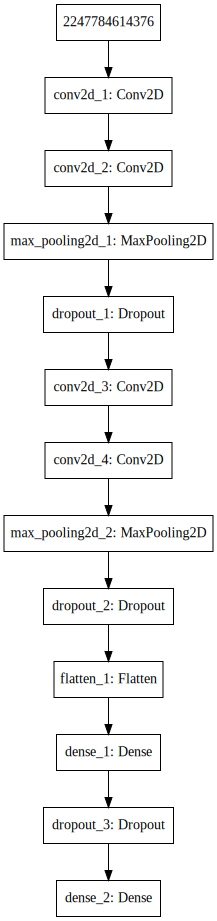

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Lets now run the model through 30 epochs and see how well our initial CNN does. We will train the above network on 8,000 images and validate each epochs on 2,000 validating images.

In [13]:
history = model.fit(X1, Y1, batch_size=32, epochs=30, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 91s 11ms/step - loss: 2.2261 - acc: 0.3786 - val_loss: 0.8806 - val_acc: 0.7600
Epoch 2/30
8000/8000 [==============================] - 94s 12ms/step - loss: 0.6932 - acc: 0.7794 - val_loss: 0.3437 - val_acc: 0.9070
Epoch 3/30
8000/8000 [==============================] - 95s 12ms/step - loss: 0.3428 - acc: 0.8879 - val_loss: 0.2251 - val_acc: 0.9385
Epoch 4/30
8000/8000 [==============================] - 94s 12ms/step - loss: 0.2326 - acc: 0.9230 - val_loss: 0.1748 - val_acc: 0.9450
Epoch 5/30
8000/8000 [==============================] - 91s 11ms/step - loss: 0.1756 - acc: 0.9425 - val_loss: 0.1400 - val_acc: 0.9580
Epoch 6/30
8000/8000 [==============================] - 92s 11ms/step - loss: 0.1385 - acc: 0.9541 - val_loss: 0.1465 - val_acc: 0.9575
Epoch 7/30
8000/8000 [==============================] - 91s 11ms/step - loss: 0.1097 - acc: 0.9630 - val_loss: 0.1597 - val_acc: 0.9550


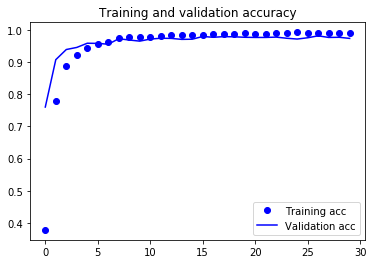

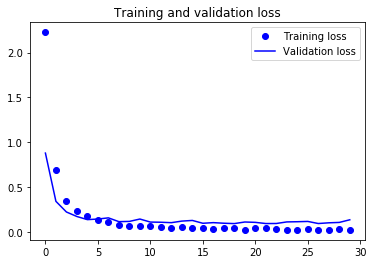

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As you can see, after running 30 epochs of backpropogation and forward propogation, we are getting an accuracy with our validation data around 97%! Given the limitations of the machine at my disposal, I think that this network is a solid start and we can move forward and test it on separate testing images. Lets now test this CNN on our testing data and see how accurate our network is.

My appraoch will be to use the CSV file of the labeling testing data to compare what our CNN will classify these images to what they truly are.

In [15]:
df = pd.read_csv('GTSRB/GT-final_test.csv', sep=';')

# Load test images
X_test = []
y_test = []
i = 0
for file_name, class_id in zip(list(df['Filename']), list(df['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/', file_name)
    X_test.append(preprocess(io.imread(img_path)))
    y_test.append(class_id)

In [17]:
# evaluate test
X_test = np.array(X_test)
y_test = np.array(y_test)
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)
print("Test images accuracy = {}".format(acc))

Test images accuracy = 0.938479809976247


This CNN when used on our testing data results in a 94% accuracy.

As we can see above, a convolutional neural network with a few layers can get a pretty high accuracy given enough images to train on. If provided a machine with more computing power, and more time to work on this type of project there are a few more things I would like to experiment on:

1) Training a deeper neural network to increase our accuracy - given this would be used in a self driving car, we need very slim amount of error to reduce accidents.

2) Testing our CNN on augmented data to test for all angles, and shapes a car my capture in scanning for traffic signs while driving.